# Modelo de clasificación por tipo de espacio

### Importaciones

In [1]:
import numpy as np
import os
import PIL
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

import seaborn as sn
import pandas as pd
from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

C:\Users\m.alvarezg1\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\m.alvarezg1\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\m.alvarezg1\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Construcción de dataset

In [2]:
#Preprocesamiento de los datos
directory="E:/TesisMA/Datos/DataAmoblado/bedroom"
#directory1="E:/TesisMA/Datos/DataB"
img_height=256
img_width=256
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))


Found 338 files belonging to 2 classes.
Using 271 files for training.
Found 338 files belonging to 2 classes.
Using 67 files for validation.


### Analisis del dataset

In [3]:
class_names = train_ds.class_names
print(class_names)
num_classes = 2

['Amoblado', 'No_amoblado']


[115, 156]


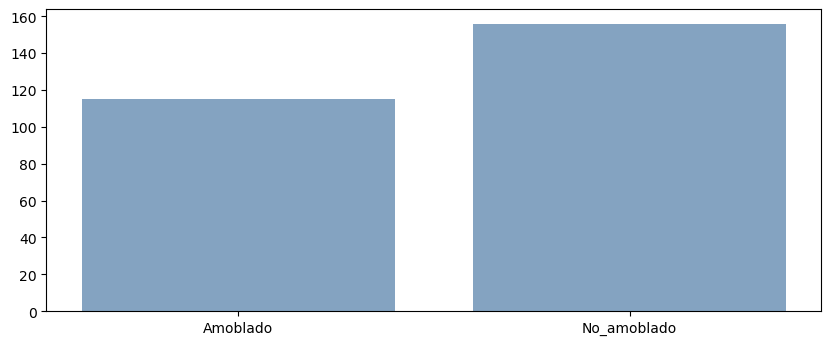

In [4]:
y = np.concatenate([y for x, y in train_ds], axis=0)
labels = list(y)
elements_per_class = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class.append(labels.count(i))
print(elements_per_class)
plt.bar(class_names,elements_per_class,color=(0.2, 0.4, 0.6, 0.6));

67


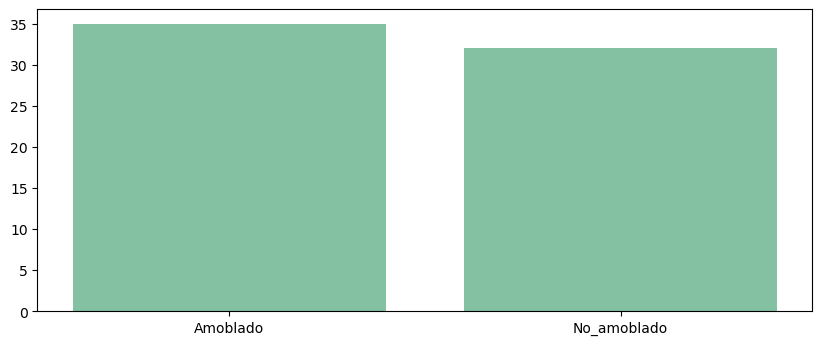

In [5]:
labels1 = np.concatenate([y for x, y in val_ds], axis=0)
labels1 = list(labels1)
elements_per_class1 = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class1.append(labels1.count(i))
print(sum(elements_per_class1))
plt.bar(class_names,elements_per_class1,color=(0.2, 0.6, 0.4, 0.6));

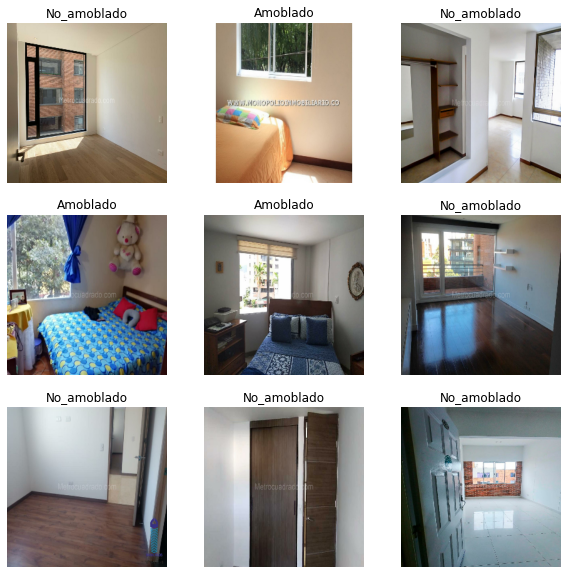

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [8]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

### CNN

In [9]:
model = Sequential([
  #Capa para realizar data augmantation
  data_augmentation,
  #Priemera capa entrada de 256x256 x3 canales de color
  layers.experimental.preprocessing.Rescaling(1/255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  #layers.BatchNormalization(),
  layers.Dense(128,activation="relu", kernel_initializer="he_normal"),
  #layers.BatchNormalization(),
  layers.Dense(64,activation="relu", kernel_initializer="he_normal"),
  #layers.BatchNormalization(),
  layers.Dense(1, activation='sigmoid')
])

### LRF Finder

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [12]:
checkpoint_filepath="E:/TesisMA/Modelos/Amoblado/First_Model_lr_0001"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
epochs=80
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs,
callbacks=[model_checkpoint_callback]
)

Epoch 1/80
9/9 [==============================] - 9s 768ms/step - loss: 0.7002 - accuracy: 0.5387 - val_loss: 0.6961 - val_accuracy: 0.4776
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/Amoblado\First_Model_lr_0001\assets
Epoch 2/80
9/9 [==============================] - 7s 733ms/step - loss: 0.6853 - accuracy: 0.5793 - val_loss: 0.6961 - val_accuracy: 0.4776
Epoch 3/80
9/9 [==============================] - 7s 725ms/step - loss: 0.6800 - accuracy: 0.5756 - val_loss: 0.6913 - val_accuracy: 0.4776
Epoch 4/80
9/9 [==============================] - 6s 721ms/step - loss: 0.6642 - accuracy: 0.5941 - val_loss: 0.6474 - val_accuracy: 0.6716
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/Amoblado\First_Model_lr_0001\assets
Epoch 5/80
9/9 [==============================] - 6s 716ms/step - loss: 0.6498 - accuracy: 0.6974 - val_loss: 0.6407 - val_accuracy: 0.6119
Epoch 6/80
9/9 [==============================] - 6s 718ms/step - loss: 0.6206 - accuracy: 0.6863 - val_loss: 0.5789 - v

Epoch 56/80
9/9 [==============================] - 7s 750ms/step - loss: 0.3497 - accuracy: 0.8339 - val_loss: 0.4266 - val_accuracy: 0.7910
Epoch 57/80
9/9 [==============================] - 7s 731ms/step - loss: 0.3811 - accuracy: 0.8118 - val_loss: 0.4853 - val_accuracy: 0.7313
Epoch 58/80
9/9 [==============================] - 7s 802ms/step - loss: 0.3805 - accuracy: 0.8192 - val_loss: 0.4621 - val_accuracy: 0.7761
Epoch 59/80
9/9 [==============================] - 7s 770ms/step - loss: 0.3894 - accuracy: 0.8266 - val_loss: 0.4582 - val_accuracy: 0.7761
Epoch 60/80
9/9 [==============================] - 7s 774ms/step - loss: 0.3801 - accuracy: 0.8229 - val_loss: 0.4273 - val_accuracy: 0.8060
Epoch 61/80
9/9 [==============================] - 7s 766ms/step - loss: 0.3609 - accuracy: 0.8413 - val_loss: 0.4284 - val_accuracy: 0.8060
Epoch 62/80
9/9 [==============================] - 7s 769ms/step - loss: 0.3898 - accuracy: 0.8155 - val_loss: 0.4301 - val_accuracy: 0.8060
Epoch 63/80
9

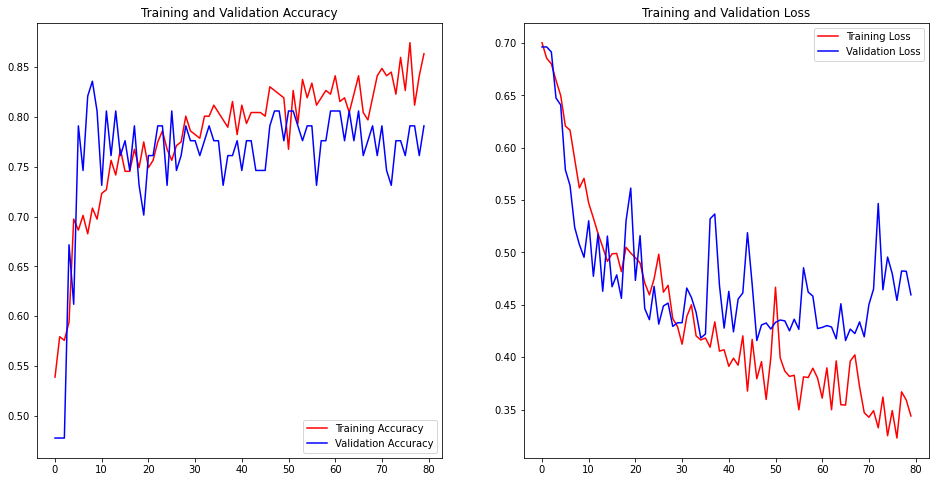

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

sn.set_palette(sn.color_palette("husl", 2))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='blue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Curva ROC

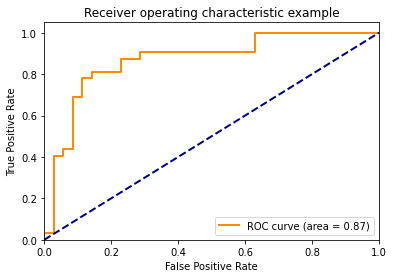

In [27]:
# Cargar mejor modelo 
model = tf.keras.models.load_model("E:/TesisMA/Modelos/Amoblado/First_Model_lr_0001")

predictions = model.predict(val_ds)
labels= np.concatenate([y for x, y in val_ds], axis=0)
# Compute ROC curve and ROC area for each class

fpr, tpr, thresholds = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)



plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [33]:
from numpy import argmax
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.461686


#### Confusion matrix

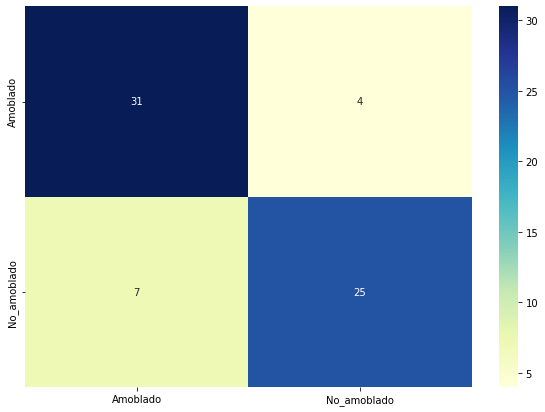

In [28]:

predictions = np.round(model.predict(val_ds))
matriz = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
df_cm = pd.DataFrame(matriz, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",  fmt='g');

In [36]:
metricasCM(matriz)

De todas las X clasificadas solo el %  fue correcto [0.82, 0.86]
De todas las que deberían ser clasificadas como X el % fue corrcto  [0.89, 0.78]


In [37]:
report = model.evaluate(val_ds,return_dict=True)
index=["Values"]
table=pd.DataFrame(report,index=index) 
table

3/3 [==============================] - 1s 109ms/step - loss: 0.5075 - accuracy: 0.8358


,loss,accuracy
Values,0.507499,0.835821


In [35]:
def metricasCM(matriz):
    # Bien clasificados sobre columna / De todas las X clasificadas solo el %  fue correcto
    metrica1= []
    # Bien clasificados sobre la fila / De todas las que deberías ser clasificadas como X solo el % fue corrcto 
    metrica2= []
    for j in range(0,2):
        suma=0
        for i in range(0,2):
            suma=suma+matriz[i][j]
        metrica1.append((matriz[j][j]/suma).round(2))
        metrica2.append((matriz[j][j]/sum(matriz[j])).round(2))
    print("De todas las X clasificadas solo el %  fue correcto",metrica1)
    print("De todas las que deberían ser clasificadas como X el % fue corrcto ",metrica2)
